### Feature Engineering with Open Source 
Replace manually created functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,)


from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

pd.pandas.set_option('display.max_columns', None)

In [2]:
# Load dataset
data = pd.read_csv('..\MLDeploy\AmesHousing.csv')
print(data.shape)
data.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Separate dataset into train and test 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Order','PID', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((2344, 79), (586, 79))

### Feature Engineering
In the following cells, we will engineer the variables of the House Price Dataset so that we tackle:

* Missing values
* Temporal variables
* Non-Gaussian distributed variables
* Categorical variables: remove rare labels
* Categorical variables: convert strings to numbers
* Standardize the values of the variables to the same range

In [4]:
# Apply log to the target

y_train = np.log(y_train)
y_test = np.log(y_test)

### Misssing values

Categorical variables
We will replace missing values with the string "missing" in those variables with a lot of missing data.

Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values.

In [5]:
# identify categorical variables
cat_vars = [var for var in data.columns if data[var].dtype == 'O']

cat_vars = cat_vars + ['MS SubClass']

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

len(cat_vars)

44

In [6]:
# make a list of the categorical variables that contain missing values
cat_vars_with_na = [var for var in cat_vars if X_train[var].isnull().sum() >0]

# print percentage of missing values per variable
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

Pool QC           0.994881
Misc Feature      0.963311
Alley             0.934727
Fence             0.796928
Fireplace Qu      0.487201
Garage Finish     0.056314
Garage Qual       0.056314
Garage Cond       0.056314
Garage Type       0.055461
Bsmt Exposure     0.030290
BsmtFin Type 2    0.029437
Bsmt Qual         0.029010
Bsmt Cond         0.029010
BsmtFin Type 1    0.029010
Mas Vnr Type      0.007679
Electrical        0.000427
dtype: float64

In [7]:
# make a list of variables to impute the string missing
with_string_missing = [var for var in cat_vars_with_na if X_train[var].isnull().mean()>0.1]

# variables to impute the frequent variables
with_frequent_category = [var for var in cat_vars_with_na if X_train[var].isnull().mean()<0.1]

In [8]:
with_string_missing

['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']

In [9]:
with_frequent_category

['Mas Vnr Type',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Electrical',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond']

In [10]:
# replace the missing values with the new label: 'Missing'

#setup the class
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing)

# fit the class to the train set
cat_imputer_missing.fit(X_train)

# the class learns and stores the parameters
cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'Fireplace Qu': 'Missing',
 'Pool QC': 'Missing',
 'Fence': 'Missing',
 'Misc Feature': 'Missing'}

In [11]:
# replace NA with missing

# Important: note that this class can be stored with joblib
X_train = cat_imputer_missing.transform(X_train)
X_test  = cat_imputer_missing.transform(X_test)

In [12]:
# replace missing values with most frequent category
cat_imputer_frequent = CategoricalImputer(
                        imputation_method='frequent', variables=with_frequent_category)

# fit 
cat_imputer_frequent.fit(X_train)

# the class learns and stores the parameters
cat_imputer_frequent.imputer_dict_

{'Mas Vnr Type': 'None',
 'Bsmt Qual': 'TA',
 'Bsmt Cond': 'TA',
 'Bsmt Exposure': 'No',
 'BsmtFin Type 1': 'GLQ',
 'BsmtFin Type 2': 'Unf',
 'Electrical': 'SBrkr',
 'Garage Type': 'Attchd',
 'Garage Finish': 'Unf',
 'Garage Qual': 'TA',
 'Garage Cond': 'TA'}

In [13]:
# replace NA with frequent category

X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)


In [14]:
[var for var in cat_vars_with_na if X_test[var].isnull().sum()>0]

[]

In [15]:
# check 
X_train[cat_vars_with_na].isnull().sum()

Alley             0
Mas Vnr Type      0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Electrical        0
Fireplace Qu      0
Garage Type       0
Garage Finish     0
Garage Qual       0
Garage Cond       0
Pool QC           0
Fence             0
Misc Feature      0
dtype: int64

### Numerical variables
* add binary missing indicator variable
* replace the missing values in the original variable with the mean

In [16]:
# identify numerical variables

num_vars = [var for var in X_train.columns if var not in cat_vars and var !='SalePrice']

len(num_vars)

35

In [17]:
vars_with_na = [var for var in num_vars if
               X_train[var].isnull().sum()>0]

X_train[vars_with_na].isnull().mean()

Lot Frontage      0.174488
Mas Vnr Area      0.007679
BsmtFin SF 1      0.000427
BsmtFin SF 2      0.000427
Bsmt Unf SF       0.000427
Total Bsmt SF     0.000427
Bsmt Full Bath    0.000853
Bsmt Half Bath    0.000853
Garage Yr Blt     0.056314
Garage Cars       0.000427
Garage Area       0.000427
dtype: float64

In [18]:
vars_with_na

['Lot Frontage',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area']

In [19]:
# add missing indicator

missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

# check the binary missing indicator variables

X_train[['Lot Frontage_na',
 'Mas Vnr Area_na',
 'BsmtFin SF 1_na',
 'BsmtFin SF 2_na',
 'Bsmt Unf SF_na',
 'Total Bsmt SF_na',
 'Bsmt Full Bath_na',
 'Bsmt Half Bath_na',
 'Garage Yr Blt_na',
 'Garage Cars_na',
 'Garage Area_na']].head()

,Lot Frontage_na,Mas Vnr Area_na,BsmtFin SF 1_na,BsmtFin SF 2_na,Bsmt Unf SF_na,Total Bsmt SF_na,Bsmt Full Bath_na,Bsmt Half Bath_na,Garage Yr Blt_na,Garage Cars_na,Garage Area_na
2073,0,0,0,0,0,0,0,0,0,0,0
2754,0,0,0,0,0,0,0,0,0,0,0
1282,0,0,0,0,0,0,0,0,0,0,0
1572,1,0,0,0,0,0,0,0,0,0,0
641,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# replace the missing data with the mean

mean_imputer = MeanMedianImputer(
                imputation_method='mean', variables=vars_with_na)

# learn and store the parameters from the train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'Lot Frontage': 69.1875968992248,
 'Mas Vnr Area': 102.17669819432503,
 'BsmtFin SF 1': 444.4835680751174,
 'BsmtFin SF 2': 51.93854033290653,
 'Bsmt Unf SF': 554.3585147247119,
 'Total Bsmt SF': 1050.7806231327359,
 'Bsmt Full Bath': 0.4372331340734415,
 'Bsmt Half Bath': 0.060204953031596925,
 'Garage Yr Blt': 1977.9046112115732,
 'Garage Cars': 1.7618437900128041,
 'Garage Area': 471.8113529662825}

In [21]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

X_train[vars_with_na].isnull().sum()

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
Garage Cars       0
Garage Area       0
dtype: int64

In [22]:
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]


[]

### Temporal Variables

* capture elapsed time
* drop unwanted features

In [23]:
# create a class manually to capture elapsed time but CombineWithFeatureReference from feature engine can be used

def elapsed_years(df,var):
    df[var] = df['Yr Sold'] - df[var]
    return df



In [24]:
for var in ['Year Built', 'Year Remod/Add', 'Garage Yr Blt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [25]:
# drop Yr Sold

drop_features = DropFeatures(features_to_drop=['Yr Sold'])

X_train = drop_features.fit_transform(X_train)
X_test = drop_features.transform(X_test)

### Numerical variable transformation

Transform numerical variables to a gausian-like distribution

In [26]:
log_transformer = LogTransformer(variables=['Lot Frontage',
                                            '1st Flr SF', 'Gr Liv Area'])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)


### Yeo-Johnson Transformation


In [27]:
yeo_transformer = YeoJohnsonTransformer(variables=['Lot Area'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

{'Lot Area': 0.10674834539872138}

In [28]:
# check for any NA's
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [29]:
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

### Binarize skewed variables
Transform the very skewed variables.

In [30]:
skewed = ['BsmtFin SF 2', 'Low Qual Fin SF', 'Enclosed Porch',
    '3Ssn Porch', 'Screen Porch', 'Misc Val']

binarizer = SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=skewed)

X_train = binarizer.fit_transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed].head()

,BsmtFin SF 2,Low Qual Fin SF,Enclosed Porch,3Ssn Porch,Screen Porch,Misc Val
2073,0.0,0.0,0.0,0.0,1.0,0.0
2754,0.0,0.0,0.0,0.0,0.0,0.0
1282,0.0,0.0,0.0,0.0,0.0,0.0
1572,1.0,0.0,1.0,0.0,0.0,0.0
641,0.0,0.0,0.0,0.0,0.0,0.0


### Categorical Variables

Assign numbers to variables that have an assigned order of quality.

In [31]:
# re-map strings that determine quality to numbers  

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
             'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
             'Garage Qual', 'Garage Cond',
            ]

for var in qual_vars:
    X_train[var]=X_train[var].map(qual_mappings)
    X_test[var]=X_test[var].map(qual_mappings)
    

In [32]:
exposure_mappings={'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'Bsmt Exposure'

X_train[var]=X_train[var].map(exposure_mappings)
X_test[var]=X_test[var].map(exposure_mappings)

In [33]:
X_train['Bsmt Exposure'].value_counts()

1    1572
3     340
4     228
2     204
Name: Bsmt Exposure, dtype: int64

In [34]:
finish_mappings={'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFin Type 1', 'BsmtFin Type 2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [35]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'Garage Finish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [36]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [37]:
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [38]:
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

### Removing rare labels
For the remaining categorical variables, group the categories that are less 1% of the categories

In [39]:
qual_vars  = qual_vars + finish_vars + ['Bsmt Exposure','Garage Finish','Fence']

cat_others = [var for var in cat_vars if var not in qual_vars]

len(cat_others)

30

In [40]:
cat_others

['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Electrical',
 'Functional',
 'Garage Type',
 'Paved Drive',
 'Pool QC',
 'Misc Feature',
 'Sale Type',
 'Sale Condition',
 'MS SubClass']

In [41]:
X_train.groupby('MS SubClass')['MS SubClass'].count()

MS SubClass
20     885
30     115
40       4
45      13
50     225
60     452
70      97
75      19
80      93
85      39
90      82
120    155
150      1
160     98
180     14
190     52
Name: MS SubClass, dtype: int64

In [42]:
X_train['MS SubClass'].value_counts()

20     885
60     452
50     225
120    155
30     115
160     98
70      97
80      93
90      82
190     52
85      39
75      19
180     14
45      13
40       4
150      1
Name: MS SubClass, dtype: int64

In [43]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'MS Zoning': Index(['RL', 'RM', 'FV'], dtype='object'),
 'Street': Index(['Pave'], dtype='object'),
 'Alley': Index(['Missing', 'Grvl', 'Pave'], dtype='object'),
 'Lot Shape': Index(['Reg', 'IR1', 'IR2'], dtype='object'),
 'Land Contour': Index(['Lvl', 'Bnk', 'HLS', 'Low'], dtype='object'),
 'Utilities': Index(['AllPub'], dtype='object'),
 'Lot Config': Index(['Inside', 'Corner', 'CulDSac', 'FR2'], dtype='object'),
 'Land Slope': Index(['Gtl', 'Mod'], dtype='object'),
 'Neighborhood': Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
        'Sawyer', 'Gilbert', 'NWAmes', 'Mitchel', 'SawyerW', 'BrkSide',
        'Crawfor', 'IDOTRR', 'Timber', 'NoRidge', 'StoneBr', 'ClearCr', 'SWISU',
        'MeadowV', 'BrDale'],
       dtype='object'),
 'Condition 1': Index(['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'], dtype='object'),
 'Condition 2': Index(['Norm'], dtype='object'),
 'Bldg Type': Index(['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'], dtype='object'),
 'House Styl

In [44]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

### Encoding Categorical Variables
Transform all the string categories into numbers. This will capture the monotonic relationship of the label and the target.

In [45]:
# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train,y_train)

# mappings are stored and the class can be saved
cat_encoder.encoder_dict_

{'MS Zoning': {'Rare': 0, 'RM': 1, 'RL': 2, 'FV': 3},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Missing': 1, 'Pave': 2},
 'Lot Shape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
 'Land Contour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'Lot Config': {'Inside': 0, 'Corner': 1, 'FR2': 2, 'Rare': 3, 'CulDSac': 4},
 'Land Slope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'OldTown': 3,
  'BrkSide': 4,
  'Edwards': 5,
  'SWISU': 6,
  'Sawyer': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'SawyerW': 10,
  'NWAmes': 11,
  'Rare': 12,
  'Gilbert': 13,
  'CollgCr': 14,
  'Crawfor': 15,
  'ClearCr': 16,
  'Somerst': 17,
  'Timber': 18,
  'StoneBr': 19,
  'NridgHt': 20,
  'NoRidge': 21},
 'Condition 1': {'Artery': 0,
  'Feedr': 1,
  'Rare': 2,
  'Norm': 3,
  'RRAn': 4,
  'PosN': 5},
 'Condition 2': {'Rare': 0, 'Norm': 1},
 'Bldg Type': {'2fmCon': 0, 'Twnhs': 1, 'Duplex': 2, '1Fam': 3, 'TwnhsE': 4

In [46]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [47]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [48]:
# check absence of na in the test set


[]

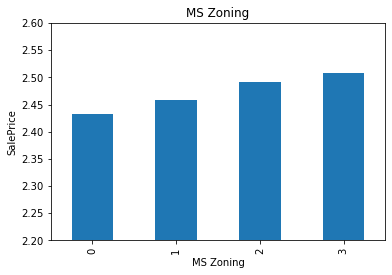

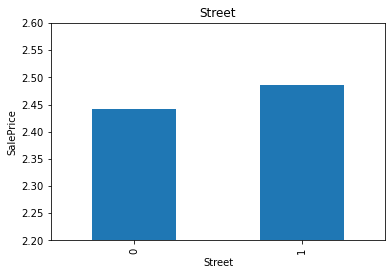

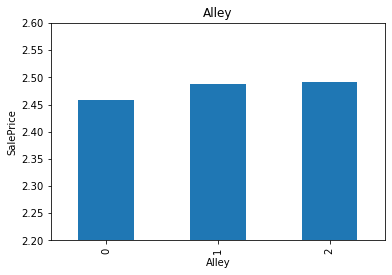

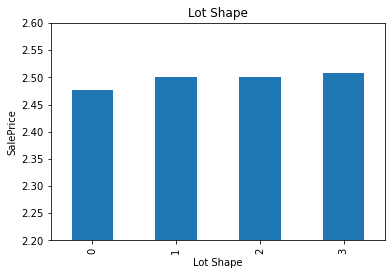

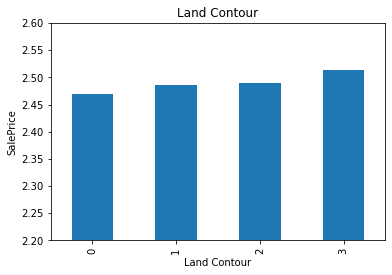

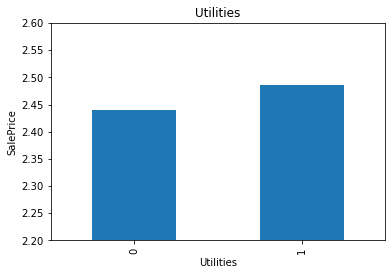

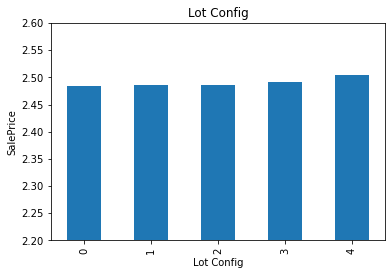

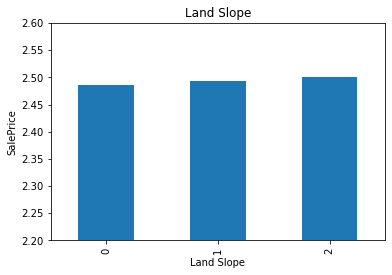

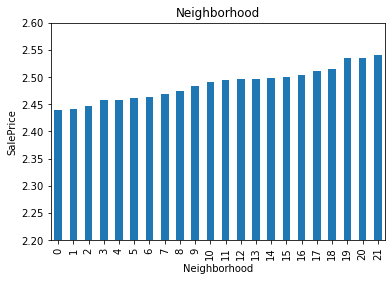

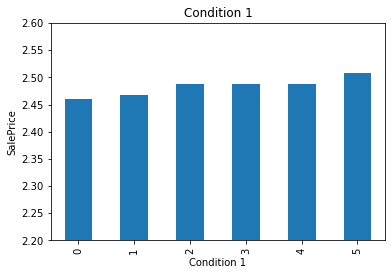

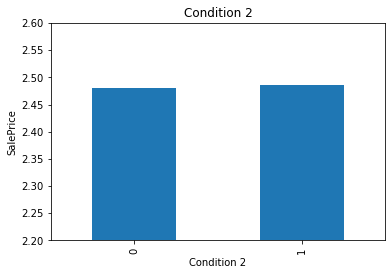

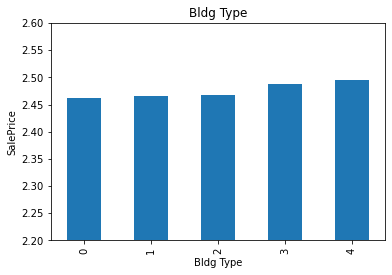

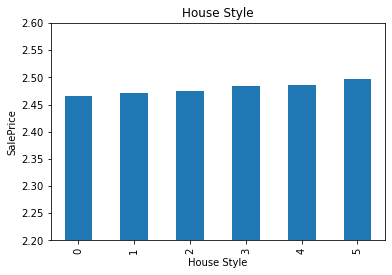

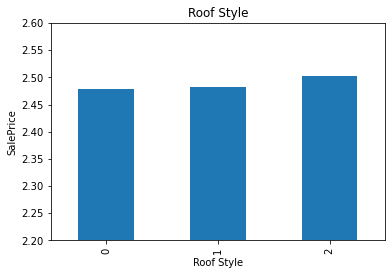

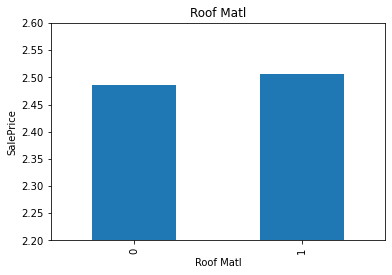

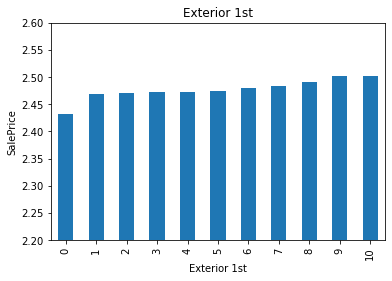

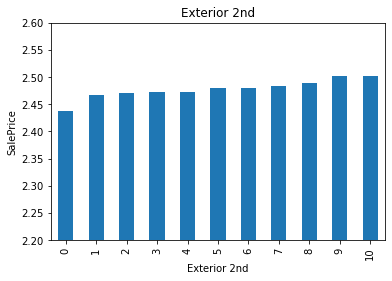

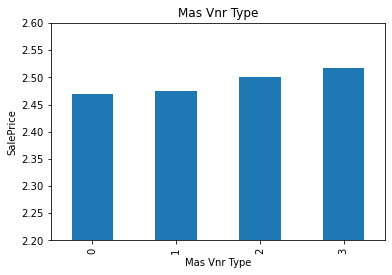

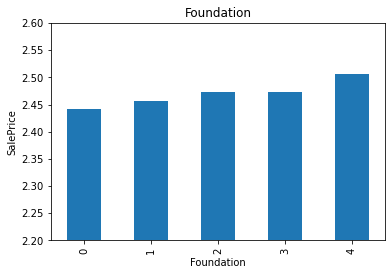

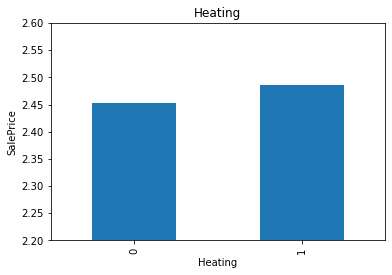

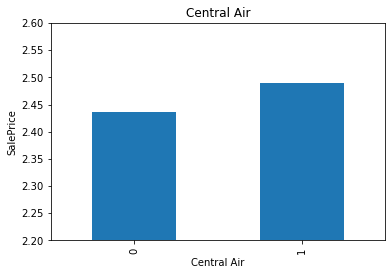

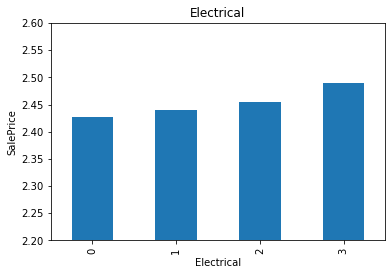

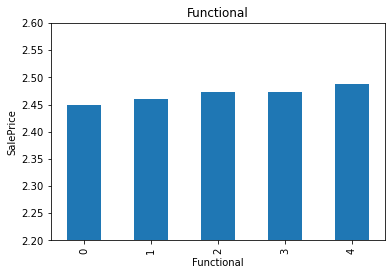

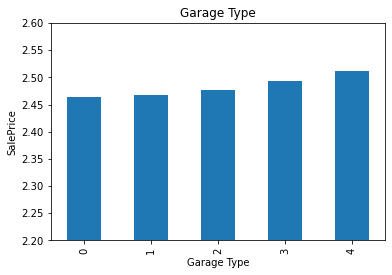

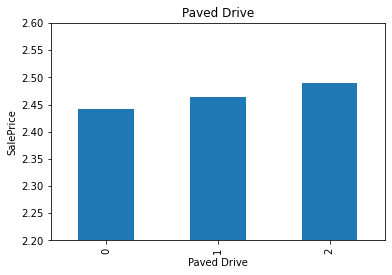

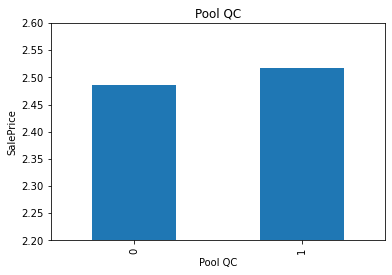

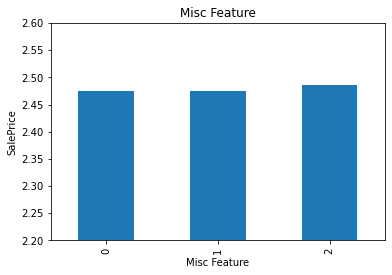

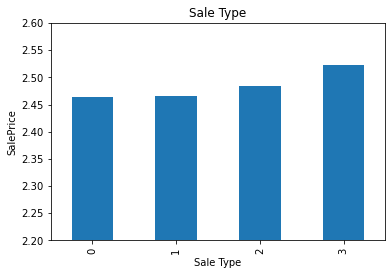

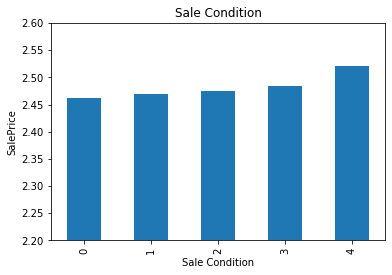

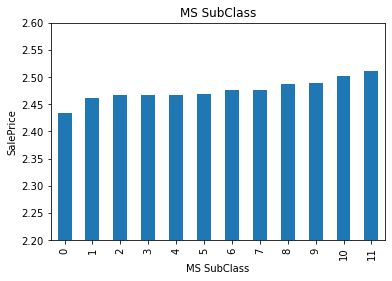

In [49]:
# monotonic relationship

def analyse_var(train, y_train, var):
    
    # function plots the mean house prioce per category
    
    tmp = pd.concat([train,np.log(y_train)], axis=1)
    tmp.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylim(2.2,2.6)
    plt.ylabel('SalePrice')
    plt.show()

for var in cat_others:
    analyse_var(X_train, y_train, var)

### Feature Scaling

Features need to be scaled in a linear model.

In [50]:
# create an instance of the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set
scaler.fit(X_train)

# transform the train and test set, as the scaler returns numpy arrays,
# they are wrapped in a pandas dataframe

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [51]:
X_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Sale Type,Sale Condition,Lot Frontage_na,Mas Vnr Area_na,BsmtFin SF 1_na,BsmtFin SF 2_na,Bsmt Unf SF_na,Total Bsmt SF_na,Bsmt Full Bath_na,Bsmt Half Bath_na,Garage Yr Blt_na,Garage Cars_na,Garage Area_na
0,1.000000,0.666667,0.566384,0.323632,1.0,0.5,0.333333,0.333333,1.0,0.25,0.0,0.761905,0.6,1.0,0.75,1.0,0.555556,0.500,0.148438,0.311475,0.5,0.0,0.7,0.7,0.666667,0.167500,0.666667,0.5,1.0,0.75,0.5,0.000000,1.0,0.147236,0.0,0.0,0.136986,0.188380,1.0,0.5,1.0,1.0,0.472465,0.433898,0.0,0.643585,0.000000,0.5,0.50,0.5,0.500,0.333333,0.50,0.500000,1.0,0.25,0.6,0.75,0.697452,0.0,0.50,0.350134,0.5,0.50,1.0,0.000000,0.307278,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.727273,0.666667,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.818182,0.666667,0.521833,0.344511,1.0,0.5,0.333333,0.333333,1.0,0.00,0.0,0.666667,0.6,1.0,0.75,0.6,0.666667,0.500,0.007812,0.016393,0.5,0.0,1.0,0.9,0.666667,0.150000,0.666667,0.5,1.0,0.75,0.5,0.666667,1.0,0.003544,0.0,0.0,0.682363,0.264157,1.0,1.0,1.0,1.0,0.596157,0.000000,0.0,0.557273,0.000000,0.0,0.50,0.0,0.375,0.333333,0.75,0.416667,1.0,0.00,0.0,0.75,0.640127,0.5,0.75,0.581317,0.5,0.50,1.0,0.101124,0.079515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.545455,1.000000,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.818182,0.666667,0.440313,0.272448,1.0,0.5,0.000000,0.333333,1.0,0.00,0.0,0.380952,1.0,1.0,0.75,0.6,0.444444,0.500,0.351562,0.754098,0.5,0.0,0.2,0.2,0.333333,0.000000,0.333333,0.5,0.5,0.50,0.5,0.000000,0.0,0.000000,0.0,0.0,0.478168,0.182815,1.0,1.0,1.0,1.0,0.456868,0.000000,0.0,0.427069,0.000000,0.0,0.25,0.0,0.375,0.333333,0.50,0.333333,1.0,0.00,0.0,0.75,0.780255,0.0,0.25,0.177419,0.5,0.50,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.363636,0.000000,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.818182,0.666667,0.441318,0.406690,1.0,0.5,0.333333,0.333333,1.0,0.25,0.0,0.857143,0.6,1.0,0.75,0.6,0.777778,0.625,0.250000,0.540984,1.0,1.0,0.4,0.5,0.333333,0.000000,0.666667,0.5,0.5,0.75,0.5,0.666667,0.8,0.206414,0.2,1.0,0.000000,0.256137,1.0,0.5,1.0,1.0,0.817656,0.000000,0.0,0.764325,0.333333,0.0,0.50,0.0,0.250,0.333333,0.75,0.666667,1.0,0.25,0.8,0.75,0.738854,1.0,0.50,0.446909,0.5,0.50,1.0,0.000000,0.097035,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.363636,0.000000,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.454545,0.666667,0.476078,0.313207,1.0,0.5,0.000000,0.333333,1.0,0.00,0.0,0.380952,0.6,1.0,0.50,0.6,0.444444,0.375,0.398438,0.852459,1.0,0.0,0.2,0.2,0.666667,0.410625,0.333333,0.5,1.0,0.50,0.5,0.000000,0.0,0.000000,0.0,0.0,0.798801,0.305401,1.0,1.0,1.0,1.0,0.651061,0.000000,0.0,0.608596,0.000000,0.0,0.50,0.0,0.500,0.666667,0.50,0.500000,1.0,0.00,0.0,0.00,0.799363,0.0,0.50,0.332661,0.5,0.25,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.666667,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
